# Base model generate test

4bit 양자화 사용하여 모델 로드, device_map="auto" (gpu 설정)

In [1]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("beomi/Llama-3-Open-Ko-8B-Instruct-preview", load_in_4bit=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("beomi/Llama-3-Open-Ko-8B-Instruct-preview")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
def generate_response(prompt, model):
    messages = [
        {"role": "user", "content": f"{prompt}"},
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=512,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.2,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )
    response = outputs[0][input_ids.shape[-1]:]
    print(tokenizer.decode(response, skip_special_tokens=True))


prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 먹, 돼지갈비, 비빔냉면, 비쌌, 맛있, 가격 ### Response:"

generate_response(prompt, model)

Here is a sentence generated using the given concept set: "The delicious pork ribs with a savory sauce and a bowl of spicy noodles is a great combination for a meal, especially when you add a side of spicy stir-fried pork and a bowl of cold noodles at a reasonable price."


In [13]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 있, 추천, 활용, 찌개, 냉동 게 ### Response:"

generate_response(prompt, model)

Here is a sentence using the given concept set: "There are various ways to enjoy frozen dumplings, such as eating them with a dipping sauce, using them as a topping, or even freezing them for later use."


In [14]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 보너스, 이야기, 기업, 나온다고, 많이 ### Response:"

generate_response(prompt, model)

Here is a generated sentence using the given concept set: "Bonus, Story, Company, and Many"!

"Many companies offer bonuses as a way to boost employee morale and productivity, which often leads to a great story."


In [15]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 이, 있, 이중 모니터, 컴퓨터 책상 위 ### Response:"

generate_response(prompt, model)

Here is a sentence generated using the given concept set: "There is a dual monitor on a computer desk."


In [16]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 샀, 오징어 다리 과자, 엄마 안주, 체리 ### Response:"

generate_response(prompt, model)

Here is a sentence using the given concept set: "My mom gave me a snack of shrimp-flavored crackers and a cherry as a treat."


In [17]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 있, 한, 창고 앞 도로, 낡, 트럭 ### Response:"

generate_response(prompt, model)

Here is a sentence generated using the concept set: "There is a truck in front of the old warehouse."


In [18]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 병원 서류, 이야기, 어렵, 위해, 보험금 청구, 필요 ### Response:"

generate_response(prompt, model)

Here is a sentence generated using the given concept set:

"병원 서류를 작성하는 것이 필요하다." 

Please note that the difficulty level of the sentence is "어렵" and the purpose is "보험금 청구" for the story.


# Fine-tuned model test

train history 출력

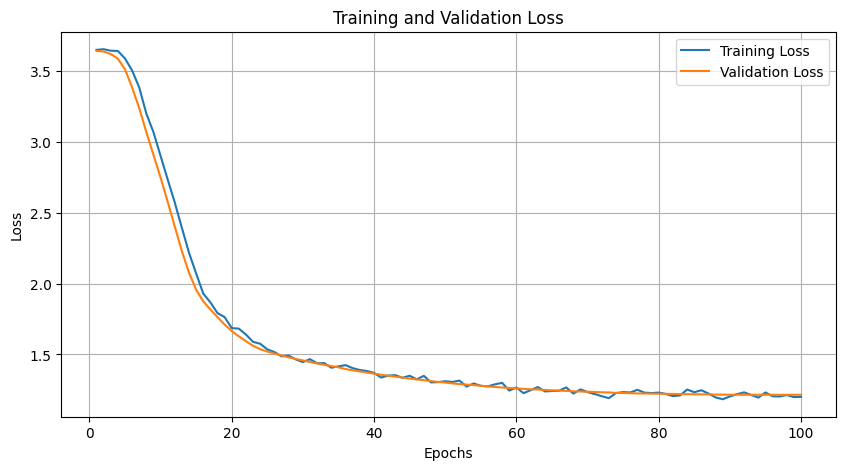

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json("C:\\Users\\Gamzadole\\Downloads\\drive-download-20240709T192446Z-001\\trainer_log_history.json")

train_loss = df ['loss'].dropna()
val_loss = df ['eval_loss'].dropna()

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

4bit 양자화 하여 베이스 모델 로드하기, LoRA로 파인튜닝한 모델을 PeftModel.from_pretrained로 함꺠 합쳐 로드 

In [1]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

config = PeftConfig.from_pretrained("gamzadole/llama3_Commonsense_Reasoning")
base_model = AutoModelForCausalLM.from_pretrained("beomi/Llama-3-Open-Ko-8B-Instruct-preview", device_map="auto", load_in_4bit=True)
model = PeftModel.from_pretrained(base_model, "gamzadole/llama3_Commonsense_Reasoning")
tokenizer = AutoTokenizer.from_pretrained("gamzadole/llama3_Commonsense_Reasoning")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
def generate_response(prompt, model):
    messages = [
        {"role": "user", "content": f"{prompt}"},
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=512,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.2,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )
    response = outputs[0][input_ids.shape[-1]:]
    print(tokenizer.decode(response, skip_special_tokens=True))


prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 먹, 돼지갈비, 비빔냉면, 비쌌, 맛있, 가격 ### Response:"

generate_response(prompt, model)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
c:\Users\Gamzadole\anaconda3\envs\tf\lib\site-packages\bitsandbytes\nn\modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
c:\Users\Gamzadole\anaconda3\envs\tf\lib\site-packages\transformers\models\llama\modeling_llama.py:648: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


비빔냉면과 돼지갈비를 먹는데 비쌌지만 맛있었다. 가격이 비쌌지만 비빔냉면과 돼지갈비는 맛있었다.


Dataset에서 랜덤 선택하여 응답출력

In [3]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 있, 추천, 활용, 찌개, 냉동 게 ### Response:"

generate_response(prompt, model)

냉동 게를 추천하고 있지만, 찌개를 활용하여 요리할 수 있다.


In [4]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 보너스, 이야기, 기업, 나온다고, 많이 ### Response:"

generate_response(prompt, model)

기업에서 보너스를 많이 나온다고 이야기한다.


In [5]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 이, 있, 이중 모니터, 컴퓨터 책상 위 ### Response:"

generate_response(prompt, model)

이중 모니터가 컴퓨터 책상 위에 있어요.


In [6]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 샀, 오징어 다리 과자, 엄마 안주, 체리 ### Response:"

generate_response(prompt, model)

체리와 오징어 다리 과자를 샀는데 엄마 안주라고 하셨다.


In [7]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 있, 한, 창고 앞 도로, 낡, 트럭 ### Response:"

generate_response(prompt, model)

트럭이 한 창고 앞 도로에 낡아서 있다.


In [8]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 병원 서류, 이야기, 어렵, 위해, 보험금 청구, 필요 ### Response:"

generate_response(prompt, model)

보험금 청구를 위해 병원 서류가 필요하다고 이야기하는데 어렵다.


데이터셋에 없는 input에 대한 출력

In [4]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 야구 선수, 부상, 병원, 2달, 휴식 ### Response:"

generate_response(prompt, model)

야구 선수가 2달간 부상으로 인해 병원에 휴식을 취하고 있다.


In [7]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 전공, 과목 , 기대, A+, B+, 실망, 공부, 다짐 ### Response:"

generate_response(prompt, model)

A+와 B+를 기대했지만 공부를 잘하지 않아 실망스럽다.


In [17]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 시험, 어려, 찍어, 맞았다, 좋은 성적, 행운 ### Response:"

generate_response(prompt, model)

시험을 잘 쳐서 좋은 성적을 맞았다고 행운이라고 한다.


In [20]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 집, 더워, 에어컨, 고장, 선풍기, 여전히  ### Response:"

generate_response(prompt, model)

여전히 에어컨이 고장 나서 선풍기만 돌아가고 집이 더워 있다.


In [35]:
prompt = "### instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 친구, 여행, 덥다, 불평, 짜증, 맛집, 웨이팅, 다른, 먹다, 맛 없다, 싸우다, 화나다  ### Response:"

generate_response(prompt, model)

여행 중 친구가 덥다며 불평하고 다른 맛집에 가자고 하지만, 웨이팅이 길어서 싸우고 있다며 화나하고 있다. 다른 친구는 먹다 말고 다른 곳에 가자고 하지만, 이 친구는 맛이 없다며 짜증을 내고 있다.


In [38]:
prompt = "주어진 개념 세트를 이용하여 문장을 생성하세요. 개념 세트: 시험, 어려, 찍어, 맞았다, 좋은 성적, 행운"

generate_response(prompt, model)

주어진 개념 세트를 이용하여 문장을 생성합니다.


In [48]:
prompt = "단어 몇개를 나열할테니 단어가 들어가는 문장 생성해봐 전공, 과목 , 기대, A+, B+, 실망, 공부, 다짐"

generate_response(prompt, model)

주어진 단어를 이용하여 문장을 생성합니다.


In [49]:
prompt = "단어 몇개를 나열할테니 단어가 들어가는 문장 생성해봐 전공, 과목 , 기대, A+, B+, 실망, 공부, 다짐"

generate_response(prompt, model)

주어진 단어를 이용하여 문장을 생성해드리겠습니다. 단어는 "전공", "과목", "기대", "A+", "B+", "공부", "다짐"입니다. 다음은 문장입니다. "전공과목에 A+와 B+를 기대하고 공부를 다짐한다."입니다.
